In [29]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from datetime import datetime
from sklearn.metrics import mean_absolute_error

In [18]:
import warnings
warnings.filterwarnings('ignore')


In [19]:
folder1 = [os.path.join(".\\DATA\\", folder) for folder in os.listdir(".\\DATA\\")]
folder1

['.\\DATA\\phone', '.\\DATA\\watch']

In [23]:
for subfolder in folder1:
    parent_dir = ".\\processed\\"
    path = os.path.join(parent_dir, os.path.basename(subfolder))
    print(path)
    folder2 = [os.path.join(subfolder, folder) for folder in os.listdir(subfolder)]
    print(folder2)

    

.\processed\phone
['.\\DATA\\phone\\accel', '.\\DATA\\phone\\gyro']
.\processed\watch
['.\\DATA\\watch\\accel', '.\\DATA\\watch\\gyro']


In [24]:
folder2

['.\\DATA\\watch\\accel', '.\\DATA\\watch\\gyro']

In [25]:
column_names = ['ID', 'activity', 'timestamp', 'x', 'y', 'z']
overall_dataframe = pd.DataFrame(columns=column_names)

folder1 = [os.path.join(".\\DATA\\", folder) for folder in os.listdir(".\\DATA\\")]

for subfolder in folder1:
    parent_dir = ".\\processed\\"
    path = os.path.join(parent_dir, os.path.basename(subfolder))
    os.makedirs(path, exist_ok=True)

    folder2 = [os.path.join(subfolder, folder) for folder in os.listdir(subfolder)]
    for subsubfolder in folder2:
        activity_dataframe = pd.DataFrame(columns=column_names)
        subfolder_path = os.path.join(path, os.path.basename(subsubfolder))
        os.makedirs(subfolder_path, exist_ok=True)

        files = [os.path.join(subsubfolder, f) for f in os.listdir(subsubfolder)]
        for file in files:
            df = pd.read_csv(file, sep=",", header=None)
            df.columns = column_names
            activity_dataframe = pd.concat([activity_dataframe, df], ignore_index=True)

        activity_dataframe['z'] = activity_dataframe['z'].str[:-1]
        activity_dataframe['meter'] = os.path.basename(subsubfolder)
        activity_dataframe['device'] = os.path.basename(subfolder)
        activity_dataframe.to_csv(os.path.join(subfolder_path, 'data.csv'), index=False)

In [26]:
df_phone_accel_orig = pd.read_csv("./processed/phone/accel/data.csv")
df_watch_accel_orig = pd.read_csv("./processed/watch/accel/data.csv")

df_phone_gyro_orig = pd.read_csv("./processed/phone/gyro/data.csv")
df_watch_gyro_orig = pd.read_csv("./processed/watch/gyro/data.csv")

In [30]:
#Function for model training

def model_train(X_train,Y_train,model_name='vanilla'):
    if(model_name=='vanilla'):
        model = Sequential()
        model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')

    elif(model_name=='stacked'):
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

    elif(model_name=='bi'):
        model = Sequential()
        model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, shuffle=False)

    model.summary()

    return model

In [31]:
#Function for creating the dataset with specified look back

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [32]:
#Function for spliting the data into train and test

def create_split(activity2check,ID2check,device,meter):
    if(device=='phone'):
        if(meter=='acc'):
            dataset = df_phone_accel_orig[df_phone_accel_orig['activity']==activity2check] # Slecting the activity
            dataset = dataset[dataset['ID']==ID2check] #Selecting the ID
        elif(meter=='gyro'):
            dataset = df_phone_gyro_orig[df_phone_gyro_orig['activity']==activity2check]
            dataset = dataset[dataset['ID']==ID2check]
    
    if(device=='watch'):
        if(meter=='acc'):
            dataset = df_watch_accel_orig[df_watch_accel_orig['activity']==activity2check] # Slecting the activity
            dataset = dataset[dataset['ID']==ID2check] #Selecting the ID
        elif(meter=='gyro'):
            dataset = df_watch_gyro_orig[df_watch_gyro_orig['activity']==activity2check]
            dataset = dataset[dataset['ID']==ID2check]

            
    dataset['avg'] = np.sqrt(dataset['x']**2 + dataset['y']**2+dataset['z']**2) #Avg accln
    dataset['timestamp']=range(0,len(dataset))
    dataset['timestamp']=pd.to_datetime(dataset['timestamp'], unit='s')
    dataset = dataset.set_index('timestamp')
    dataset=dataset.drop(columns=['ID', 'activity','meter','device','x','y','z'])
    values = dataset.values
    dataset = dataset.avg.values 
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.66)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return dataset,train,test,scaler

In [33]:
#Function for plotting the graph

def plot_graph(dataset,train_predict,test_predict,look_back):
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

    print(len(trainPredictPlot))
    plt.figure(figsize=(20,6))
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [34]:
dataset,train,test,scaler=create_split('P',1600,'phone','acc')

In [35]:
look_back = 200
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [36]:
model=model_train(X_train,Y_train,'stacked')

Epoch 1/100
34/34 [==============================] - 6s 17ms/step - loss: 0.0191
Epoch 2/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0055
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0052
Epoch 4/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0052
Epoch 5/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0051
Epoch 6/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0051
Epoch 7/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0051
Epoch 8/100
34/34 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 9/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 10/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 11/100
34/34 [==============================] - 0s 15ms/step - loss: 0.0049
Epoch 12/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 13/100
34/34 [=====

In [37]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

32/32 [==============================] - 0s 5ms/step
Train Mean Absolute Error: 0.6536396133548422
Train Root Mean Squared Error: 0.8925114195537165
Test Mean Absolute Error: 0.7307128132929197
Test Root Mean Squared Error: 0.9974733911256326


3574


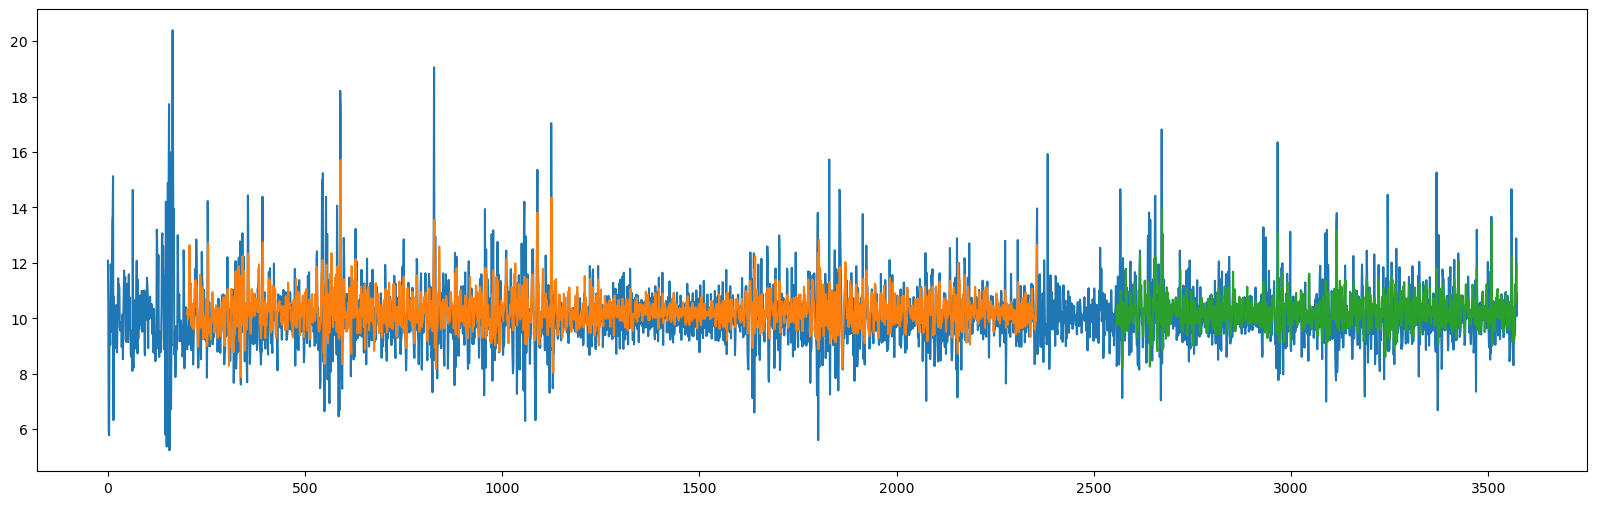

In [38]:
plot_graph(dataset,train_predict,test_predict,look_back)

## Gyroscope Modelling

In [39]:
dataset,train,test,scaler=create_split('P',1600,'phone','gyro')

In [40]:
look_back = 200
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [41]:
model_train(X_train,Y_train,'stacked')

Epoch 1/100
34/34 [==============================] - 3s 15ms/step - loss: 0.0122
Epoch 2/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0079
Epoch 3/100
34/34 [==============================] - 0s 12ms/step - loss: 0.0072
Epoch 4/100
34/34 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 5/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0058
Epoch 6/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 7/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 8/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0046
Epoch 9/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 10/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0041
Epoch 11/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0039
Epoch 12/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0038
Epoch 13/100
34/34 [=====

In [42]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

32/32 [==============================] - 0s 5ms/step
Train Mean Absolute Error: 0.7639617366699073
Train Root Mean Squared Error: 0.8462066427578072
Test Mean Absolute Error: 0.7690707005880257
Test Root Mean Squared Error: 0.847228989887706


3570


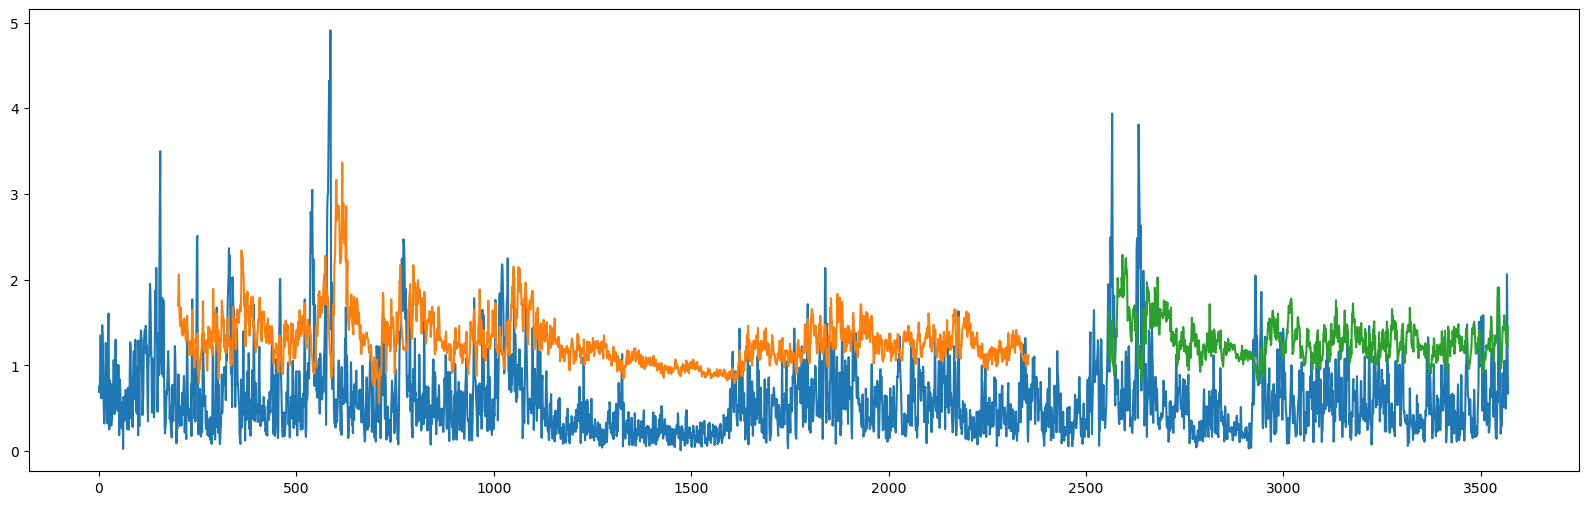

In [43]:
plot_graph(dataset,train_predict,test_predict,look_back)